In [1]:
import numpy as np
import tensorflow as tf

/home/lotuswhl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
corpus_raw = 'He is the king . The king is royal . The queen is royal . She is the royal  queen '

### 将输入文本转换为小写

In [3]:
corpus_raw = corpus_raw.lower()

### 构建文本的词典

In [4]:
words = []

In [5]:
for word in corpus_raw.split():
    if word != '.': # 不将标点看做单词
        words.append(word)

In [6]:
words

['he',
 'is',
 'the',
 'king',
 'the',
 'king',
 'is',
 'royal',
 'the',
 'queen',
 'is',
 'royal',
 'she',
 'is',
 'the',
 'royal',
 'queen']

In [7]:
words = set(words) # 去除重复词汇

In [8]:
words

{'he', 'is', 'king', 'queen', 'royal', 'she', 'the'}

接下来构建单词与数字的相互映射词典

In [9]:
word2num={}
num2word={}

In [10]:
for num,word in enumerate(words):
    word2num[word]=num
    num2word[num]=word

做下测试

In [11]:
word2num['royal']

1

In [12]:
num2word[5]

'the'

接下来将我们的语料库逐句转换为词汇表示

In [13]:
sentences=[]

In [14]:
for sentence in corpus_raw.split('.'):
    sentences.append(sentence.split())
        

In [15]:
sentences

[['he', 'is', 'the', 'king'],
 ['the', 'king', 'is', 'royal'],
 ['the', 'queen', 'is', 'royal'],
 ['she', 'is', 'the', 'royal', 'queen']]

### 接下来我们要生成训练数据
我们将使用skip-gram 算法,也就是根据输入词汇预测其周围词汇的概率
因此 我们需要根据上面分隔好的词汇组成的句子去生成诸如{'he','is'},{'he','the'}这样的词组;具体的取决于gram window size的大小,从而决定一个单词生成几个词组

In [16]:
data=[]
WINDOW_SIZE=2

In [17]:
for sentence in sentences:
    for word_index,word in enumerate(sentence):
        for ng_word in sentence[max(0,word_index-WINDOW_SIZE):
                                min(word_index+WINDOW_SIZE+1,len(sentence))]:
            if ng_word != word:
                data.append([word,ng_word])

In [18]:
data

[['he', 'is'],
 ['he', 'the'],
 ['is', 'he'],
 ['is', 'the'],
 ['is', 'king'],
 ['the', 'he'],
 ['the', 'is'],
 ['the', 'king'],
 ['king', 'is'],
 ['king', 'the'],
 ['the', 'king'],
 ['the', 'is'],
 ['king', 'the'],
 ['king', 'is'],
 ['king', 'royal'],
 ['is', 'the'],
 ['is', 'king'],
 ['is', 'royal'],
 ['royal', 'king'],
 ['royal', 'is'],
 ['the', 'queen'],
 ['the', 'is'],
 ['queen', 'the'],
 ['queen', 'is'],
 ['queen', 'royal'],
 ['is', 'the'],
 ['is', 'queen'],
 ['is', 'royal'],
 ['royal', 'queen'],
 ['royal', 'is'],
 ['she', 'is'],
 ['she', 'the'],
 ['is', 'she'],
 ['is', 'the'],
 ['is', 'royal'],
 ['the', 'she'],
 ['the', 'is'],
 ['the', 'royal'],
 ['the', 'queen'],
 ['royal', 'is'],
 ['royal', 'the'],
 ['royal', 'queen'],
 ['queen', 'the'],
 ['queen', 'royal']]

In [19]:
vacabulary_size = len(words)

In [20]:
def to_oneHot(index,vacab_size):
    oneHot_vec = np.zeros(vacab_size)
    oneHot_vec[index]=1
    return oneHot_vec

接下来构建我们的训练数据,也就是将词组转换成onehot向量构成的向量组

In [21]:
train_x = []
train_y = []

In [22]:
for word_pair in data:
    train_x.append(to_oneHot(word2num[word_pair[0]],vacabulary_size))
    train_y.append(to_oneHot(word2num[word_pair[1]],vacabulary_size))

In [23]:
len(train_x)

44

In [24]:
len(train_y)

44

再将他们转换成numpy数组方面后续操作

In [25]:
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

In [26]:
print(train_x[0:5])
print(train_y[0:5])

[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [27]:
train_x.shape

(44, 7)

In [28]:
train_y.shape

(44, 7)

有了训练数据,现在就可以构建我们的网络了

In [29]:
x=tf.placeholder(tf.float32,shape=[None,vacabulary_size])
y_=tf.placeholder(tf.float32,shape=[None,vacabulary_size])

我们将要构建一个网络,只有一层隐层,然后使用这一层隐层的值作为我们的目标embedding

In [30]:
embedding_size=hidden_size=5 # 因为我们的词汇量vacabulary_size为7,所以我们希望构建一个小于他的向量

In [31]:
w1 = tf.Variable(tf.random_normal(shape=[vacabulary_size,embedding_size]))
b1 = tf.Variable(tf.random_normal(shape=[embedding_size])) # biases

In [32]:
hidden_layer = tf.add(tf.matmul(x,w1),b1)

In [33]:
w2 = tf.Variable(tf.random_normal(shape=[embedding_size,vacabulary_size]))
b2 = tf.Variable(tf.random_normal(shape=[vacabulary_size]))

In [34]:
y_pred = tf.add(tf.matmul(hidden_layer,w2),b2)

In [35]:
y_softmax = tf.nn.softmax(y_pred,axis=1)

所以,我们的目标是实现one_hot vector --> embedings  --> input word neighbor probability

In [36]:
init = tf.global_variables_initializer()

In [37]:
sess = tf.Session()

In [38]:
# cross entropy loss define
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_softmax),axis=1))

In [39]:
# use gradient descent optimizer
optim = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

In [40]:
nIters = 10000

In [41]:
sess.run(init)

In [42]:
for i in range(nIters):
    sess.run(optim,feed_dict={x:train_x,y_:train_y})
    if i% 1000 ==0:
        print("loss is :",sess.run(cross_entropy_loss,feed_dict={x:train_x,y_:train_y}))
print("train done!")

loss is : 3.713114
loss is : 1.3740807
loss is : 1.3653294
loss is : 1.3636146
loss is : 1.3629444
loss is : 1.3625973
loss is : 1.3623884
loss is : 1.3622497
loss is : 1.3621517
loss is : 1.3620791
train done!


In [43]:
print(sess.run(w1))

[[ 2.0404618  -2.8020809   0.60984844  0.93457043  0.18032508]
 [ 2.3382154   0.58353245 -0.5876934  -0.13913979  1.2269977 ]
 [-1.0649415   1.4285247  -0.41733813 -0.23755352 -0.20523444]
 [-1.3687102  -1.3037876  -1.1744163   0.596278    0.0518599 ]
 [-1.9236883  -0.01062022  1.3702127  -0.23605892  0.99357176]
 [ 0.2056583  -1.2235731   0.8092315  -2.7232547   0.9354071 ]
 [-0.7842573   0.95953614  0.40230122  0.42348516  1.3618242 ]]


In [44]:
print(sess.run(b1))

[-0.668807    1.5817069   1.2045853   0.9268311   0.86226654]


In [45]:
embeddings = w1+b1

In [46]:
print(sess.run(embeddings))

[[ 1.3716547  -1.220374    1.8144338   1.8614016   1.0425916 ]
 [ 1.6694083   2.1652393   0.6168919   0.78769135  2.0892644 ]
 [-1.7337486   3.0102315   0.7872472   0.6892776   0.65703213]
 [-2.037517    0.2779193   0.03016901  1.5231092   0.91412646]
 [-2.5924954   1.5710866   2.574798    0.6907722   1.8558383 ]
 [-0.4631487   0.3581338   2.0138168  -1.7964236   1.7976737 ]
 [-1.4530643   2.541243    1.6068865   1.3503163   2.2240906 ]]


In [47]:
sess.run(hidden_layer,feed_dict={x:train_x,y_:train_y})

array([[-1.7337486 ,  3.0102315 ,  0.7872472 ,  0.6892776 ,  0.65703213],
       [-1.7337486 ,  3.0102315 ,  0.7872472 ,  0.6892776 ,  0.65703213],
       [ 1.3716547 , -1.220374  ,  1.8144338 ,  1.8614016 ,  1.0425916 ],
       [ 1.3716547 , -1.220374  ,  1.8144338 ,  1.8614016 ,  1.0425916 ],
       [ 1.3716547 , -1.220374  ,  1.8144338 ,  1.8614016 ,  1.0425916 ],
       [-0.4631487 ,  0.3581338 ,  2.0138168 , -1.7964236 ,  1.7976737 ],
       [-0.4631487 ,  0.3581338 ,  2.0138168 , -1.7964236 ,  1.7976737 ],
       [-0.4631487 ,  0.3581338 ,  2.0138168 , -1.7964236 ,  1.7976737 ],
       [-2.5924954 ,  1.5710866 ,  2.574798  ,  0.6907722 ,  1.8558383 ],
       [-2.5924954 ,  1.5710866 ,  2.574798  ,  0.6907722 ,  1.8558383 ],
       [-0.4631487 ,  0.3581338 ,  2.0138168 , -1.7964236 ,  1.7976737 ],
       [-0.4631487 ,  0.3581338 ,  2.0138168 , -1.7964236 ,  1.7976737 ],
       [-2.5924954 ,  1.5710866 ,  2.574798  ,  0.6907722 ,  1.8558383 ],
       [-2.5924954 ,  1.5710866 ,  2.5

In [48]:
king_num = word2num['king']
print(king_num)
king_embedding = embeddings[king_num]
print(sess.run(king_embedding))

4
[-2.5924954  1.5710866  2.574798   0.6907722  1.8558383]


In [49]:
embeddings = sess.run(embeddings)

next,let's have some fun with thoese embeddings

In [50]:
def euclidien_distance(vec1,vec2):
    return np.sqrt(np.sum(np.square(vec1-vec2)))

In [51]:
def find_closest_embedding(word_index,embeddings):
    query_embedding = embeddings[word_index]
    
    min_distance = 100000
    min_index = -1 # 最近的embedding的index
    for index,embedding in enumerate(embeddings):
        if not np.array_equal(embedding,query_embedding):
            distance = euclidien_distance(embedding,query_embedding)
            if distance < min_distance:
                min_distance = distance
                min_index = index
    return min_index
    

In [52]:
closest_index_to_king = find_closest_embedding(king_num,embeddings)

In [53]:
print(num2word[closest_index_to_king])

she


In [54]:
print(num2word[find_closest_embedding(word2num['queen'],embeddings)])

he


In [55]:
print(num2word[find_closest_embedding(word2num['king'],embeddings)])

she


In [56]:
print(num2word[find_closest_embedding(word2num['royal'],embeddings)])

she


In [57]:
print(num2word[find_closest_embedding(word2num['she'],embeddings)])

king


让我们来看看这些词向量之间的关系

In [58]:
from sklearn.manifold import TSNE

In [59]:
# 使用tsne model来降维观察
tsne_model = TSNE(n_components=2,random_state=0)
np.set_printoptions(suppress=True) # 0 to 0
embeddings = tsne_model.fit_transform(embeddings)

In [60]:
# 然后需要对词向量进行归一化,方便matplotlib显示
from sklearn import preprocessing
norm = preprocessing.Normalizer()
embeddings = norm.fit_transform(embeddings,'l2')

In [61]:
import matplotlib.pyplot as plt

is 0.9003202 -0.43522823
royal -0.9410435 0.33828554
he -0.097218975 -0.99526304
queen 0.8215789 0.5700948
king -0.7727457 -0.6347157
the -0.13745865 0.9905075
she 0.113266796 -0.9935646


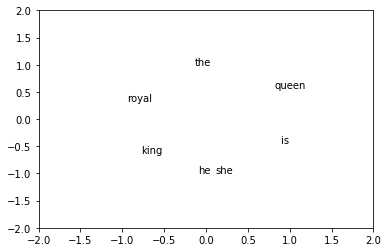

In [62]:
fig,axes = plt.subplots()
plt.xlim((-2,2))
plt.ylim((-2,2))
for word in words:
    print(word,embeddings[word2num[word]][0],embeddings[word2num[word]][1])
    axes.annotate(word,(embeddings[word2num[word]][0],embeddings[word2num[word]][1]))
plt.show()